# MiniRun6 LRS tutorial 3b

In [29]:
import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm
from matplotlib import colors, ticker
import itertools

!pip install ./h5flow
from h5flow.data import dereference
from proto_nd_flow.util.lut import LUT
import time

ERROR: Invalid requirement: './h5flow': Expected package name at the start of dependency specifier
    ./h5flow
    ^
Hint: It looks like a path. File './h5flow' does not exist.


In [30]:
# load csv generated in lrs_sanity_check from yaml file proto_nd_flow
channel_status = pd.read_csv('/global/homes/j/jvmead/dune/lrs_sanity_check/channel_status/channel_status.csv', header=None).to_numpy()
print('Channel Status Shape:', np.shape(channel_status))

# load calibration csv as df
path = '/global/homes/j/jvmead/dune/lrs_sanity_check/calibration/data_calib.csv'
calib = pd.read_csv(path, header=None).to_numpy()
print(calib.shape)


fname = '/global/cfs/cdirs/dune/www/data/2x2/reflows/v11/flow/beam/july10_2024/nominal_hv/packet-0050018-2024_07_10_12_56_35_CDT.FLOW.hdf5'
f = h5py.File(fname)

Channel Status Shape: (8, 64)
(8, 64)


In [31]:
max_events = 100
events = np.linspace(0,max_events,max_events+1,dtype=int)

light_wvfms = f['light/wvfm/data/']['samples'][events]/4.0
print(light_wvfms.shape)

sipm_hits = f['light/sipm_hits/data']
print(sipm_hits.dtype.names)
print(sipm_hits.shape)

(101, 8, 64, 1000)
('id', 'adc', 'chan', 'pos', 'sample_idx', 'ns', 'busy_ns', 'samples', 'sum', 'max', 'sum_spline', 'max_spline', 'ns_spline', 'rising_spline', 'rising_err_spline', 'fwhm_spline')
(112327,)


In [32]:
# get min_range_baseline from ndlar_flow.proto_nd_flow.reco.light.assertwvfm_noise_filter
# https://github.com/DUNE/ndlar_flow/blob/11ff23d46d5071cbd2618a12112d8db01903f72e/src/proto_nd_flow/reco/light/wvfm_noise_filter.py#L97-L123
def min_range_baseline(array, segment_size=25, num_segments=40, num_means=4):

    # Define start and end indices for segments
    indices = np.arange(num_segments + 1) * segment_size  # (41,)
    start_indices, end_indices = indices[:-1], indices[1:]  # (40,)

    # Generate index array for advanced indexing
    segment_range = np.arange(segment_size)  # (25,)
    index_array = start_indices[:, None] + segment_range  # Shape: (40, 25)

    # Extract data from segments using indexing
    sliced_data = array[..., index_array]  # Shape (..., 40, 25)

    # Compute range (peak-to-peak difference) and mean for each segment
    ranges = np.abs(np.ptp(sliced_data, axis=-1))  # Shape (..., 40)
    means = np.mean(sliced_data, axis=-1)  # Shape (..., 40)

    # Mask zero ranges
    mask_zero = (ranges != 0)
    ranges = np.where(mask_zero, ranges, np.nan)
    means = np.where(mask_zero, means, np.nan)

    # Find the ordering of the segments based on the smallest range
    smallest_ordering = np.argsort(ranges, axis=-1)  # Shape (..., 40)

    # Sort means according to the ordering of smallest ranges
    sorted_means = np.take_along_axis(means, smallest_ordering, axis=-1)  # Shape (..., 40)

    # Compute the average of the 2nd, 3rd, and 4th smallest means
    average_mean = np.mean(sorted_means[..., 1:num_means], axis=-1)  # Shape (...)

    # calculate RMS for the ranges of the smallest range segments
    rms = np.sqrt(np.mean(np.square(np.take_along_axis(ranges, smallest_ordering[..., :num_means], axis=-1)), axis=-1))

    return average_mean, rms

baselines, rms = min_range_baseline(light_wvfms)
print(baselines.shape)
print(rms.shape)

(101, 8, 64)
(101, 8, 64)


In [33]:
light_wvfms_baselined = light_wvfms - baselines[:, :, :, np.newaxis]
print(light_wvfms_baselined.shape)
cwvfms = light_wvfms_baselined * calib[np.newaxis, :, :, np.newaxis]
rms_calib = rms * calib[np.newaxis, :, :]

(101, 8, 64, 1000)


In [34]:
# a function to get the 6 channels on the same EPCB
def get_epcb_channels(channel):
    if channel < 0 or channel > 63:
        return []  # invalid
    epcb = channel // 6
    return [(epcb * 6 + i) for i in range(6)]

# a function which takes the ADC and channel and gives a TPC number
def adc_channel_to_tpc(adc, channel):

    # use channels to determine if channel is in odd or even TPC
    if channel < 0 or channel > 63:
        return -1  # invalid
    if adc < 0 or adc > 7:
        return -1  # invalid
    tpc = adc + (channel // 32)
    tpc -= 1 if (adc % 2) else 0
    return tpc

# a function which takes a TPC number and gives a list of (adc, channel) tuples
def tpc_to_adc_channel(tpc):
    if tpc < 0 or tpc > 7:
        return []  # invalid
    channel_start = (tpc % 2) * 32
    channel_list = range(channel_start, channel_start + 32)
    channel_list = [ch for ch in channel_list if channel_status[tpc, ch] >= 0]

    adc_list = [tpc]
    if tpc % 2 == 0:
        adc_list.append(tpc + 1)
    else:
        adc_list.append(tpc - 1)

    adc_channel_list = [(adc, ch) for adc in adc_list for ch in channel_list]
    return adc_channel_list

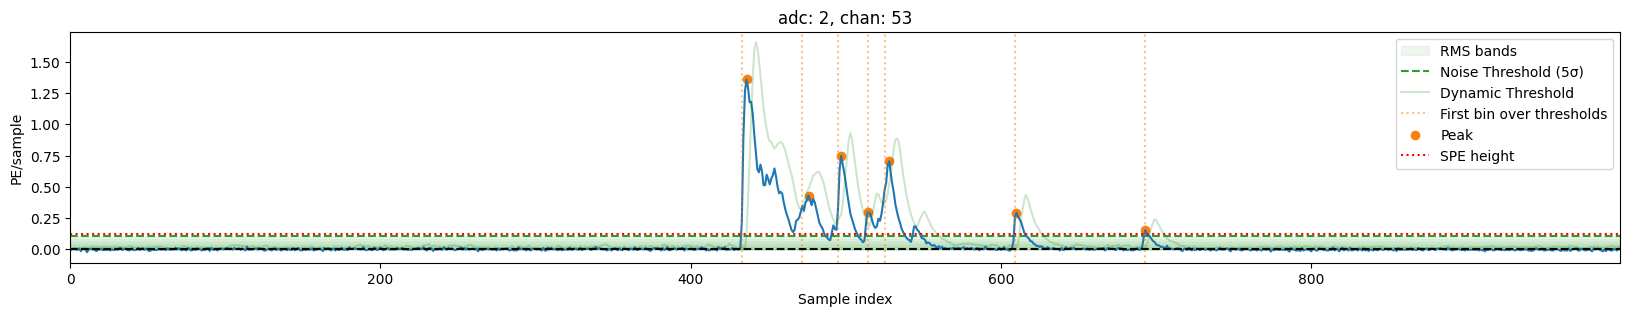

In [35]:
from scipy.ndimage import uniform_filter1d

def plot_waveform_with_hit_finder(wvfm, noise, adc, chan,
                                  n_noise_factor,
                                  n_bins_rolled,
                                  n_sqrt_rt_factor,
                                  pe_weight=0.12):

    # height = flat threshold over noise (n*sigma)
    height = n_noise_factor * noise[..., np.newaxis] * np.ones(wvfm.shape[-1])

    # dynamic_threshold = rolling threshold of previous 5 bins + n*sqrt(rolling threshold)
    wvfm_rolled = np.roll(wvfm, n_bins_rolled)
    rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
    sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
    sqrt_rolling_average[sqrt_rolling_average == 0] = 1
    dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average

    # find bins over dynamic threshold and noise floor
    bins_over_dynamic_threshold = (wvfm > dynamic_threshold) & (wvfm > height)

    # Find first bins over threshold (rising edge)
    first_bins_over = bins_over_dynamic_threshold.copy()
    first_bins_over[..., 1:] &= ~bins_over_dynamic_threshold[..., :-1]

    # check 5 bins after first_bins_over and add argmax
    peak_bins = np.zeros_like(wvfm, dtype=bool)
    first_bins_indices = np.where(first_bins_over)
    for idx in zip(*first_bins_indices):
        start_idx = idx[-1]
        end_idx = min(start_idx + 5, wvfm.shape[-1])
        peak_bin = np.argmax(wvfm[idx[:-1] + (slice(start_idx, end_idx),)])
        peak_bins[idx[:-1] + (start_idx + peak_bin,)] = True
    hits = np.where(peak_bins)[-1] if np.any(peak_bins) else np.array([])

    plt.figure(figsize=(20, 3))
    n_rms = 5
    for k in range(1, n_noise_factor + 1):
        plt.fill_between(
            np.arange(len(wvfm)),
            0 * noise,
            k * noise,
            color='tab:green', alpha=0.08, label=f'RMS bands' if k == 1 else None
        )
    plt.axhline(n_rms * noise, color='tab:green', label=f'Noise Threshold ({n_rms}σ)', linestyle='--')
    plt.plot(wvfm)
    plt.plot(dynamic_threshold, label='Dynamic Threshold', color='green', alpha=0.2)
    # for each hit in hits, plot a orange dot
    if np.any(hits):
        for i, bin in enumerate(first_bins_indices[0]):
            label = f'First bin over thresholds' if i == 0 else None
            plt.axvline(bin, color='tab:orange', linestyle=':',
                        alpha=0.5, label=label)
        plt.scatter(hits, wvfm[hits], label='Peak', c='tab:orange')
    plt.axhline(0, color='black', linestyle='--')
    plt.axhline(pe_weight, color='r', linestyle=':', label='SPE height')
    plt.xlabel('Sample index')
    plt.ylabel('PE/sample')
    plt.legend()
    plt.xlim(0, len(wvfm)-1)
    plt.title(f'adc: {adc}, chan: {chan}')
    plt.show()

# example usage
evt = 3
adc = 2
chan = 53
plot_waveform_with_hit_finder(wvfm=cwvfms[evt, adc, chan],
                              noise=rms_calib[evt, adc, chan],
                              adc=adc,
                              chan=chan,
                              n_noise_factor=5,
                              n_bins_rolled=5,
                              n_sqrt_rt_factor=3,
                              pe_weight=0.12)

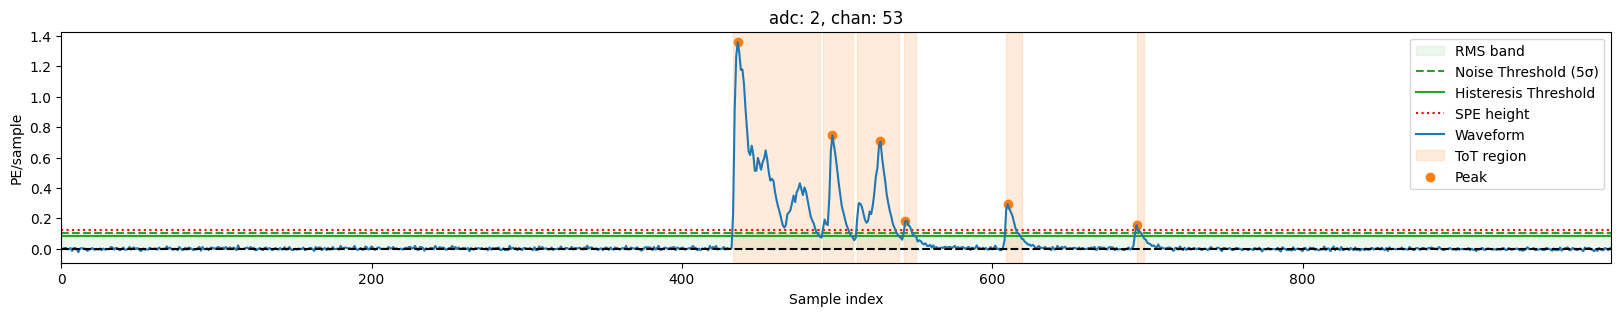

In [36]:
def plot_waveform_with_tot_peak_finder(wvfm, noise, adc, chan,
                                       n_noise_factor=5,
                                       n_hyst_factor=1,
                                       pe_height=0.12):

    time_bins = np.arange(len(wvfm))

    # thresholds
    height = n_noise_factor * noise
    neg_height = n_hyst_factor * noise

    # initialize hits
    hits = []

    # Find hits (ToT regions)
    bins_over_threshold = np.where(wvfm > height)[0]
    bins_below_threshold = np.where(wvfm < height - neg_height)[0]

    while len(bins_over_threshold) > 0:
        t_i = bins_over_threshold[0]
        bins_below_after_ti = bins_below_threshold[bins_below_threshold > t_i]
        if len(bins_below_after_ti) == 0:
            break
        t_f = bins_below_after_ti[0]

        if t_i == 0:
            bins_over_threshold = bins_over_threshold[bins_over_threshold > t_f]
            continue

        t0 = time_bins[t_i]
        tf = time_bins[t_f]
        tot = tf - t0

        hit_window = wvfm[t_i : t_f+1]
        max_height = np.max(hit_window)
        t_max_idx = t_i + np.argmax(hit_window)
        t_max = time_bins[t_max_idx]
        integral = np.sum(hit_window)

        hits.append((t0, tf, tot, t_max, max_height, integral))
        bins_over_threshold = bins_over_threshold[bins_over_threshold > t_f]

    plt.figure(figsize=(20, 3))
    plt.fill_between(time_bins, 0, height, color='tab:green', alpha=0.08, label='RMS band')
    plt.axhline(height, color='tab:green', label=f'Noise Threshold ({n_noise_factor}σ)', linestyle='--')
    plt.axhline(height-neg_height, color='tab:green', label=f'Histeresis Threshold')
    plt.axhline(pe_height, color='r', linestyle=':', label='SPE height')
    plt.plot(wvfm, label='Waveform')
    # Mark ToT regions and peaks
    for i, (t0, tf, _, t_max, max_height, _) in enumerate(hits):
        plt.axvspan(t0, tf, color='tab:orange', alpha=0.15, label='ToT region' if i == 0 else None)
        plt.scatter([t_max], [max_height], color='tab:orange', label='Peak' if i == 0 else None)
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('PE/sample')
    plt.legend()
    plt.xlim(0, len(wvfm)-1)
    plt.title(f'adc: {adc}, chan: {chan}')
    plt.show()

# example usage
evt = 3
adc = 2
chan = 53

plot_waveform_with_tot_peak_finder(wvfm=cwvfms[evt, adc, chan],
                                   noise=rms_calib[evt, adc, chan],
                                   adc=adc, chan=chan)


In [37]:
def tot_peak_finder(wvfm,
                    noise,
                    n_noise_factor=5,
                    n_hyst_factor=1):
    """
    Identify Time-over-Threshold (ToT) peaks and return a feature tensor where
    only the start sample (t_start) of each hit is populated; all other samples are NaN.

    Parameters
    ----------
    wvfm : np.ndarray
        Waveforms with shape (n_events, n_adc, n_channels, n_samples) or (n_samples,).
    noise : float or np.ndarray
        Baseline noise level(s). Can be scalar or broadcastable to (n_events, n_adc, n_channels).
    n_noise_factor : float
        Multiplier for the main threshold.
    n_hyst_factor : float
        Hysteresis factor; falling threshold is (height - neg_height).

    Returns
    -------
    hits : np.ndarray
        Array with shape (n_events, n_adc, n_channels, n_samples, 4),
        where the last axis packs [tot, t_max, max_height, integral].
        Only entries at indices corresponding to t_start are filled; other samples are NaN.
    """
    # Normalize input to 4D leading dims + samples
    if wvfm.ndim == 1:
        wvfm = wvfm[None, None, None, :]  # (1,1,1,n_samples)

    if wvfm.ndim != 4:
        raise ValueError("wvfm must be 1D or have shape (n_events, n_adc, n_channels, n_samples)")

    n_events, n_adc, n_channels, n_samples = wvfm.shape
    lead_dims = (n_events, n_adc, n_channels)

    # Prepare thresholds with broadcasting over leading dims
    height = n_noise_factor * np.asarray(noise)
    neg_height = n_hyst_factor * np.asarray(noise)

    # Broadcast to leading dims
    height = np.broadcast_to(height, lead_dims)
    neg_height = np.broadcast_to(neg_height, lead_dims)

    # Output tensor: fill with NaNs; float dtype to hold NaNs
    hits = np.full((*lead_dims, n_samples, 5), np.nan, dtype=float)

    # Iterate over all waveforms in leading dims
    for idx in np.ndindex(*lead_dims):
        trace = wvfm[idx + (slice(None),)]  # 1D (n_samples,)
        h = float(height[idx])
        nh = float(neg_height[idx])

        # Thresholds
        main_thr = h
        fall_thr = h - nh

        # Precompute indices above/below thresholds
        bins_over_threshold = np.flatnonzero(trace > main_thr)
        bins_below_threshold = np.flatnonzero(trace < fall_thr)

        # Walk through hits
        pos_ptr = 0  # pointer in bins_over_threshold (array is sorted ascending)
        while pos_ptr < len(bins_over_threshold):
            t_i = bins_over_threshold[pos_ptr]

            # Find first below-threshold sample after t_i using binary search
            # (bins_below_threshold is sorted ascending)
            # np.searchsorted returns insertion position to keep order
            j = np.searchsorted(bins_below_threshold, t_i + 1)
            if j >= len(bins_below_threshold):
                break  # no falling edge -> incomplete hit at end; ignore

            t_f = bins_below_threshold[j]

            # If the hit starts at sample 0, skip (can't compute leading edge cleanly)
            if t_i == 0:
                # advance pos_ptr to the first "over" strictly after t_f
                pos_ptr = np.searchsorted(bins_over_threshold, t_f + 1)
                continue

            # Compute features
            t0 = t_i
            tf = t_f
            tot = float(tf - t0)

            hit_window = trace[t_i: t_f + 1]
            max_height = float(np.max(hit_window))
            t_max_idx = int(t_i + int(np.argmax(hit_window)))
            integral = float(np.sum(hit_window))

            # Store features at the max sample only
            hits[idx + (t_max_idx, 0)] = t0
            hits[idx + (t_max_idx, 1)] = tf
            hits[idx + (t_max_idx, 2)] = tot
            hits[idx + (t_max_idx, 3)] = max_height
            hits[idx + (t_max_idx, 4)] = integral

            # Advance to first "over" strictly after t_f
            pos_ptr = np.searchsorted(bins_over_threshold, t_f + 1)

    return hits

In [38]:
# get min_range_baseline from ndlar_flow.proto_nd_flow.reco.light.assertwvfm_noise_filter
# https://github.com/DUNE/ndlar_flow/blob/11ff23d46d5071cbd2618a12112d8db01903f72e/src/proto_nd_flow/reco/light/hit_finder.py#L189-L231

def peak_finder(#self,
                wvfm, noise,
                n_noise_factor = 5,
                n_bins_rolled = 5,
                n_sqrt_rt_factor = 3,
                pe_weight = 0.12,
                use_rising_edge=False,
                use_local_maxima=True):

    # height = flat threshold over noise (n*sigma)
    height = n_noise_factor * noise[..., np.newaxis] * np.ones(wvfm.shape[-1])
    # dynamic_threshold = rolling threshold of previous 5 bins + n*sqrt(rolling threshold)
    wvfm_rolled = np.roll(wvfm, n_bins_rolled)
    rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
    sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
    sqrt_rolling_average[sqrt_rolling_average == 0] = 1
    dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
    # find bins over dynamic threshold and noise floor
    bins_over_dynamic_threshold = (wvfm > dynamic_threshold) & (wvfm > height)
    # Find first bins over threshold (rising edge)
    first_bins_over = bins_over_dynamic_threshold.copy()
    first_bins_over[..., 1:] &= ~bins_over_dynamic_threshold[..., :-1]
    if use_rising_edge:
        return first_bins_over
    # Peak finding
    elif use_local_maxima:
        # check 5 bins after first_bins_over and add argmax
        peak_bins = np.zeros_like(wvfm, dtype=bool)
        first_bins_indices = np.where(first_bins_over)
        for idx in zip(*first_bins_indices):
            start_idx = idx[-1]
            end_idx = min(start_idx + 5, wvfm.shape[-1])
            peak_bin = np.argmax(wvfm[idx[:-1] + (slice(start_idx, end_idx),)])
            peak_bins[idx[:-1] + (start_idx + peak_bin,)] = True
    else:
        # Derivative-based peak detection
        wvfm_d1 = np.gradient(wvfm, axis=-1)
        wvfm_d2 = np.gradient(wvfm_d1, axis=-1)
        peak_bins = (wvfm > dynamic_threshold) & (wvfm > height) & \
            (wvfm_d1 < 0) & (wvfm_d2 < 0)
        # Keep only the first peak in consecutive runs
        peak_bins[..., 1:] &= ~peak_bins[..., :-1]

    return peak_bins


# generate hits from waveforms using peak_finder
#sipm_hits = peak_finder(wvfm=cwvfms, noise=rms_calib)

Rolling TH peak_finder took 1.87 seconds for 100 events


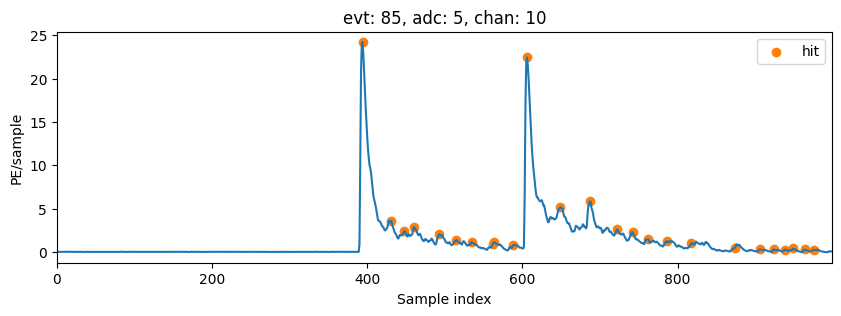

In [ ]:
# speed test for rolling threshold peak_finder
start = time.time()
rth_sipm_hits = peak_finder(wvfm=cwvfms,
                                noise=rms_calib)
end = time.time()
print(f'Rolling TH peak_finder took {end - start:.2f} seconds for {max_events} events')

# Example usage:
#plot_waveforms_with_hits(cwvfms, rth_sipm_hits, channel_status, event_ids=None,
#                         exclude_mod0=False, require_hits=True, max_nplots=5)

evt = 85  # example event
adc = 5  # example ADC number
chan = 10  # example channel number

plt.figure(figsize=(20, 3))
plt.plot(cwvfms[evt, adc, chan])
# for each hit in hits, plot a orange dot
if np.any(rth_sipm_hits[evt, adc, chan]):
    hit_idx = np.where(rth_sipm_hits[evt, adc, chan])[0]
    plt.scatter(hit_idx, cwvfms[evt, adc, chan][hit_idx], label='hit', c='tab:orange')
plt.xlabel('Sample index')
plt.ylabel('PE/sample')
plt.legend()
plt.xlim(0, len(cwvfms[evt, adc, chan])-1)
plt.title(f'evt: {evt}, adc: {adc}, chan: {chan}')
plt.show()

ToT peak_finder took 1.73 seconds for 100 events


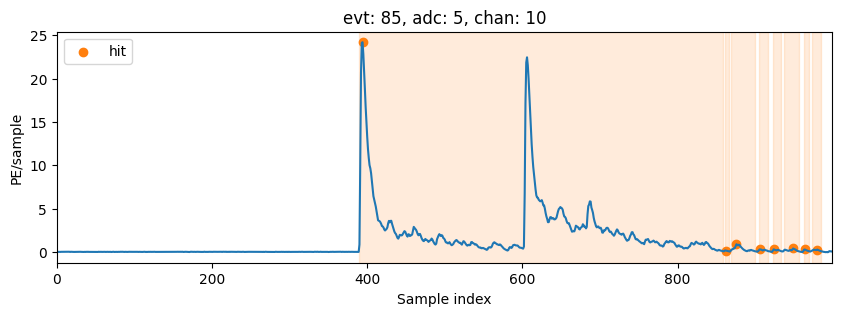

In [ ]:
# speed test for ToT peak_finder
start = time.time()
tot_sipm_hits = tot_peak_finder(wvfm=cwvfms,
                                noise=rms_calib)
tot_sipm_hits_tmax = np.where(~np.isnan(tot_sipm_hits[..., 0]), True, False)
tmax_indices = np.where(tot_sipm_hits_tmax[..., 0])[0]
# get first sample over threshold
tot_sipm_hits_t0s = np.zeros_like(tot_sipm_hits_tmax)
for idx in zip(*tmax_indices):
    t0 = int(tot_sipm_hits[idx[:-1] + (idx[-1], 0)])
    tot_sipm_hits_t0s[idx[:-1] + (t0,)] = True
# get final sample over threshold
tot_sipm_hits_tfs = np.zeros_like(tot_sipm_hits_tmax)
for idx in zip(*tmax_indices):
    tf = int(tot_sipm_hits[idx[:-1] + (idx[-1], 1)])
    tot_sipm_hits_tfs[idx[:-1] + (tf,)] = True

end = time.time()
print(f'ToT peak_finder took {end - start:.2f} seconds for {max_events} events')

evt = 85  # example event
adc = 5  # example ADC number
chan = 10  # example channel number

plt.figure(figsize=(20, 3))
plt.plot(cwvfms[evt, adc, chan])
# for each hit in hits, plot a orange dot
if np.any(tot_sipm_hits_tmax[evt, adc, chan]):
    # plot t0-tf range as shaded region
    for idx in zip(*np.where(tot_sipm_hits_tmax[evt, adc, chan])):
        t0 = int(tot_sipm_hits[evt, adc, chan, idx[0], 0])
        tf = int(tot_sipm_hits[evt, adc, chan, idx[0], 1])
        plt.axvspan(t0, tf, color='tab:orange', alpha=0.15)
    hit_idx = np.where(tot_sipm_hits_tmax[evt, adc, chan])[0]
    plt.scatter(hit_idx, cwvfms[evt, adc, chan][hit_idx], label='hit', c='tab:orange')


plt.xlabel('Sample index')
plt.ylabel('PE/sample')
plt.legend()
plt.xlim(0, len(cwvfms[evt, adc, chan])-1)
plt.title(f'evt: {evt}, adc: {adc}, chan: {chan}')
plt.show()

Splitting overlapping pulses using the 'natural breaks' algorithm?

In [ ]:
def natural_breaks_algorithm(data, n_clusters):
    """
    Jenks natural breaks on 1D data (your routine, kept as-is).
    Returns list of break values (length n_clusters+1, with [.., max(data)]).
    """
    data = np.asarray(data)
    data = data[~np.isnan(data)]
    data.sort()
    n_data = len(data)
    if n_data == 0 or n_clusters <= 1:
        return [data[0] if n_data else 0.0] * n_clusters + ([data[-1]] if n_data else [0.0])

    mat1 = np.zeros((n_data + 1, n_clusters + 1))
    mat2 = np.zeros((n_data + 1, n_clusters + 1))
    for i in range(1, n_clusters + 1):
        mat1[0][i] = 1
        mat2[0][i] = 0
        for j in range(1, n_data + 1):
            mat2[j][i] = float('inf')
    v = 0.0
    for l in range(2, n_data + 1):
        s1 = s2 = w = 0.0
        for m in range(1, l + 1):
            i3 = l - m + 1
            val = data[i3 - 1]
            s2 += val * val
            s1 += val
            w += 1.0
            v = s2 - (s1 * s1) / w
            i4 = i3 - 1
            if i4 != 0:
                for j in range(2, n_clusters + 1):
                    if mat2[l][j] >= v + mat2[i4][j - 1]:
                        mat1[l][j] = i3
                        mat2[l][j] = v + mat2[i4][j - 1]
        mat1[l][1] = 1
        mat2[l][1] = v
    k = n_data
    kclass = [0.0] * (n_clusters + 1)
    kclass[n_clusters] = float(data[-1])
    count_num = n_clusters
    while count_num >= 2:
        idx = int((mat1[k][count_num]) - 2)
        kclass[count_num - 1] = data[idx]
        k = int((mat1[k][count_num] - 1))
        count_num -= 1
    return kclass



In [ ]:
def tot_splitter_with_jenks(
    wvfm,
    noise,
    n_noise_factor=5.0,
    n_hyst_factor=1.0,
    # splitting controls
    max_splits=3,                 # maximum sub-pulses per ToT region
    min_separation=2,             # minimum samples between sub-pulse t_max’s
    peak_prominence=0.1,          # relative to local max (0..1): ignore tiny shoulders
    weight_scale=50.0,            # converts amplitude to repetition count for Jenks
    max_weighted_samples=2000,    # cap to keep Jenks fast per window
    min_cluster_width=2           # minimum width (samples) for a valid sub-pulse
):
    """
    Time-over-Threshold peak finder that *splits overlapping pulses* inside each
    ToT region using Jenks natural breaks on time indices weighted by amplitude.

    Output shape and packing matches your ToT finder:
    returns (..., n_samples, 5) where the last axis holds:
        [t_start, t_end, tot, max_height, integral]
    Only the sample at t_max of each (sub)pulse is populated; others are NaN.
    """
    # Normalize input to 4D leading dims + samples
    if wvfm.ndim == 1:
        wvfm = wvfm[None, None, None, :]
    if wvfm.ndim != 4:
        raise ValueError("wvfm must be 1D or have shape (n_events, n_adc, n_channels, n_samples)")

    n_events, n_adc, n_channels, n_samples = wvfm.shape
    lead_dims = (n_events, n_adc, n_channels)

    # Thresholds broadcast
    height = n_noise_factor * np.asarray(noise)
    neg_height = n_hyst_factor * np.asarray(noise)
    height = np.broadcast_to(height, lead_dims)
    neg_height = np.broadcast_to(neg_height, lead_dims)

    out = np.full((*lead_dims, n_samples, 5), np.nan, dtype=float)

    # Helper: fast local maxima finder (no scipy), returns sorted indices
    def _local_maxima(x):
        # interior points: greater than neighbors
        if x.size < 3:
            return np.array([], dtype=int)
        dx1 = x[1:-1] - x[:-2]
        dx2 = x[1:-1] - x[2:]
        peaks = np.nonzero((dx1 > 0) & (dx2 > 0))[0] + 1
        return peaks

    # Helper: split one ToT window [t0:tf] into subwindows via Jenks on weighted times
    def _split_window(trace, t0, tf):
        # Extract window (inclusive of tf)
        seg = trace[t0:tf+1]
        if seg.size <= 3:
            return [(t0, tf)]

        # Find candidate peaks (coarse)
        rel = seg / (np.max(seg) + 1e-12)
        cand = _local_maxima(rel)

        # Filter tiny shoulders by prominence against nearest valley
        keep = []
        for p in cand:
            # left valley
            lv = p - 1
            while lv > 0 and seg[lv-1] <= seg[lv]:
                lv -= 1
            # right valley
            rv = p + 1
            while rv < seg.size-1 and seg[rv+1] <= seg[rv]:
                rv += 1
            base = max(seg[lv], seg[rv])
            prom = seg[p] - base
            if prom >= peak_prominence * seg[p]:
                keep.append(p)
        peaks = np.array(keep, dtype=int)

        if peaks.size <= 1:
            return [(t0, tf)]

        # Limit number of splits
        n_clusters = min(peaks.size, max_splits)

        # Build weighted time list: indices (in absolute samples) repeated ~ amplitude
        # Scale amplitudes, cap total size to keep Jenks fast
        amp = seg.astype(float)
        weights = np.clip(np.round(amp / (amp.max() + 1e-12) * weight_scale), 1, None).astype(int)
        # If this would be too many, thin uniformly
        total_rep = weights.sum()
        if total_rep > max_weighted_samples:
            scale = max_weighted_samples / total_rep
            weights = np.maximum(1, np.floor(weights * scale)).astype(int)

        if weights.sum() < n_clusters:  # degenerate (too thin)
            return [(t0, tf)]

        idxs_abs = np.arange(t0, tf+1, dtype=int)
        weighted_times = np.repeat(idxs_abs, weights)

        # Jenks on weighted time positions to get split thresholds
        breaks = natural_breaks_algorithm(weighted_times, n_clusters=n_clusters)
        # Convert break "values" into cluster edges in sample indices
        # breaks is length n_clusters+1 with last equal to max(time)
        # We turn these into rising boundaries, then map to integer edges
        cut_vals = np.array(breaks[1:-1], dtype=float)  # internal cuts only
        # boundaries are nearest integer sample positions
        cuts = np.unique(np.clip(np.rint(cut_vals).astype(int), t0+1, tf-1))

        if cuts.size == 0:
            return [(t0, tf)]

        # Build subwindows by cutting at valleys nearest to each cut
        edges = [t0]
        prev = t0
        for c in cuts:
            # search in a small neighborhood around cut for a local minimum to avoid cutting on a shoulder
            left = max(prev+1, c-2)
            right = min(tf-1, c+2)
            sub = trace[left:right+1]
            if sub.size == 0:
                continue
            vrel = left + int(np.argmin(sub))
            if vrel - edges[-1] >= min_cluster_width:
                edges.append(vrel)
                prev = vrel
        if tf - edges[-1] >= min_cluster_width:
            edges.append(tf)

        # Form (start, end) pairs; enforce minimum width
        pairs = []
        for s, e in zip(edges[:-1], edges[1:]):
            if e - s >= min_cluster_width:
                pairs.append((s, e))
        if not pairs:  # fallback
            pairs = [(t0, tf)]
        return pairs

    # Iterate over channels (vectorizing across samples inside each loop)
    for idx in np.ndindex(*lead_dims):
        trace = wvfm[idx + (slice(None),)]
        h = float(height[idx])
        nh = float(neg_height[idx])
        main_thr = h
        fall_thr = h - nh

        # Precompute threshold crossings
        over = np.flatnonzero(trace > main_thr)
        under = np.flatnonzero(trace < fall_thr)

        pos_ptr = 0
        while pos_ptr < len(over):
            t_i = over[pos_ptr]
            j = np.searchsorted(under, t_i + 1)
            if j >= len(under):
                break  # no falling edge
            t_f = under[j]
            if t_i == 0:
                pos_ptr = np.searchsorted(over, t_f + 1)
                continue

            # split into subwindows
            subwindows = _split_window(trace, t_i, t_f)

            for (s0, sf) in subwindows:
                seg = trace[s0:sf+1]
                if seg.size == 0:
                    continue
                t_max_off = int(np.argmax(seg))
                t_max = s0 + t_max_off
                max_h = float(seg[t_max_off])
                tot = float(sf - s0)
                integ = float(np.sum(seg))

                out[idx + (t_max, 0)] = s0
                out[idx + (t_max, 1)] = sf
                out[idx + (t_max, 2)] = tot
                out[idx + (t_max, 3)] = max_h
                out[idx + (t_max, 4)] = integ

            # advance beyond this ToT region
            pos_ptr = np.searchsorted(over, t_f + 1)

    return out


ToT+splitter peak_finder took 883.97 seconds for 100 events


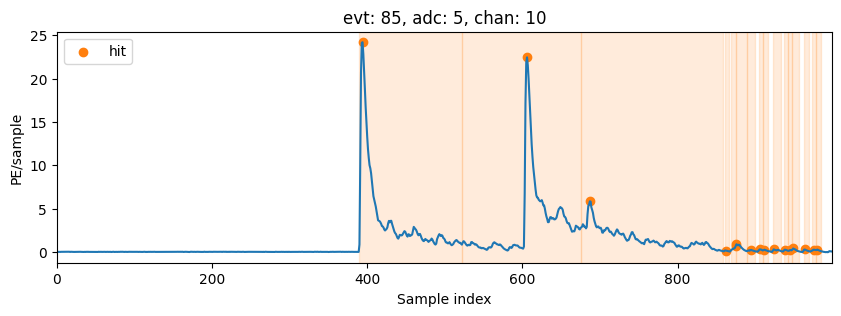

In [ ]:
start = time.time()

tot_splitter_sipm_hits = tot_splitter_with_jenks(wvfm=cwvfms,
                                                noise=rms_calib)
tot_splitter_sipm_hits_tmax = np.where(~np.isnan(tot_splitter_sipm_hits[..., 0]), True, False)
tmax_indices = np.where(tot_splitter_sipm_hits_tmax[..., 0])[0]
# get first sample over threshold
tot_splitter_sipm_hits_t0s = np.zeros_like(tot_splitter_sipm_hits_tmax)
for idx in zip(*tmax_indices):
    t0 = int(tot_splitter_sipm_hits[idx[:-1] + (idx[-1], 0)])
    tot_splitter_sipm_hits_t0s[idx[:-1] + (t0,)] = True
# get final sample over threshold
tot_splitter_sipm_hits_tfs = np.zeros_like(tot_splitter_sipm_hits_tmax)
for idx in zip(*tmax_indices):
    tf = int(tot_splitter_sipm_hits[idx[:-1] + (idx[-1], 1)])
    tot_splitter_sipm_hits_tfs[idx[:-1] + (tf,)] = True

end = time.time()
print(f'ToT+splitter peak_finder took {end - start:.2f} seconds for {max_events} events')


plt.figure(figsize=(20, 3))
plt.plot(cwvfms[evt, adc, chan])
# for each hit in hits, plot a orange dot
if np.any(tot_splitter_sipm_hits_tmax[evt, adc, chan]):
    # plot t0-tf range as shaded region
    for idx in zip(*np.where(tot_splitter_sipm_hits_tmax[evt, adc, chan])):
        t0 = int(tot_splitter_sipm_hits[evt, adc, chan, idx[0], 0])
        tf = int(tot_splitter_sipm_hits[evt, adc, chan, idx[0], 1])
        plt.axvspan(t0, tf, color='tab:orange', alpha=0.15)
    hit_idx = np.where(tot_splitter_sipm_hits_tmax[evt, adc, chan])[0]
    plt.scatter(hit_idx, cwvfms[evt, adc, chan][hit_idx], label='hit', c='tab:orange')
plt.xlabel('Sample index')
plt.ylabel('PE/sample')
plt.legend()
plt.xlim(0, len(cwvfms[evt, adc, chan])-1)
plt.title(f'evt: {evt}, adc: {adc}, chan: {chan}')
plt.show()

Faster "valley splitter" ?

ToT+valley-splitter peak_finder took 7.99 seconds for 100 events


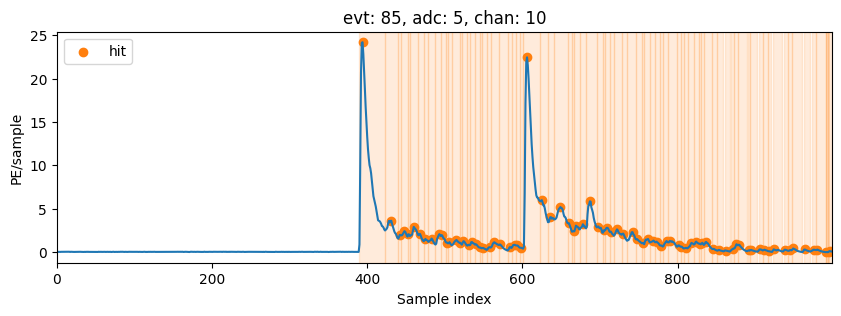

In [58]:
def tot_splitter_valley(
    wvfm,
    noise,
    n_noise_factor=5.0,
    n_hyst_factor=1.0,
    # splitting controls (cheap, O(n))
    min_separation=2,        # minimum samples between sub-peak t_max’s
    min_width=2,             # minimum samples for a valid subwindow
    valley_prom_frac=0.10,   # valley must drop by >= this fraction of the higher adjacent peak
    smooth_window=1          # optional box smoothing inside ToT (odd int; 1 disables)
):
    """
    Fast ToT peak finder with *overlap splitting by valleys*.

    Output: (..., n_samples, 5) float array, NaN everywhere except at t_max of each (sub)pulse:
        [t_start, t_end, tot, max_height, integral]
    """
    # Normalize input to 4D leading dims + samples
    if wvfm.ndim == 1:
        wvfm = wvfm[None, None, None, :]
    if wvfm.ndim != 4:
        raise ValueError("wvfm must be 1D or have shape (n_events, n_adc, n_channels, n_samples)")

    n_events, n_adc, n_channels, n_samples = wvfm.shape
    lead_dims = (n_events, n_adc, n_channels)

    # Thresholds broadcast
    height = n_noise_factor * np.asarray(noise)
    neg_height = n_hyst_factor * np.asarray(noise)
    height = np.broadcast_to(height, lead_dims)
    neg_height = np.broadcast_to(neg_height, lead_dims)

    out = np.full((*lead_dims, n_samples, 5), np.nan, dtype=float)

    # helpers
    def _local_maxima(x):
        if x.size < 3:
            return np.array([], dtype=int)
        return np.flatnonzero((x[1:-1] > x[:-2]) & (x[1:-1] > x[2:])) + 1

    def _local_minima(x):
        if x.size < 3:
            return np.array([], dtype=int)
        return np.flatnonzero((x[1:-1] <= x[:-2]) & (x[1:-1] <= x[2:])) + 1

    def _maybe_smooth(seg):
        if smooth_window and smooth_window > 1:
            w = int(smooth_window) | 1  # force odd
            if w > seg.size:
                return seg  # too short to smooth
            k = np.ones(w, dtype=float) / w
            return np.convolve(seg, k, mode='same')
        return seg

    def _split_by_valleys(trace, t0, tf):
        """Return list of (s,e) inside [t0,tf] inclusive."""
        seg = trace[t0:tf+1]
        if seg.size <= 3:
            return [(t0, tf)]

        seg_sm = _maybe_smooth(seg)
        peaks = _local_maxima(seg_sm)
        if peaks.size <= 1:
            return [(t0, tf)]

        mins = _local_minima(seg_sm)
        if mins.size == 0:
            return [(t0, tf)]

        # keep only minima that sit between adjacent peaks
        # for each adjacent peak pair, find minima indices in between
        cut_idxs = []
        for i in range(len(peaks) - 1):
            pL, pR = peaks[i], peaks[i+1]
            if pR - pL < min_separation:
                continue
            m_between = mins[(mins > pL) & (mins < pR)]
            if m_between.size == 0:
                continue
            # choose the *deepest* valley between these peaks
            m = int(m_between[np.argmin(seg_sm[m_between])])
            valley = seg_sm[m]
            left_peak = seg_sm[pL]
            right_peak = seg_sm[pR]
            # require sufficient drop wrt the higher of the two peaks
            high_peak = max(left_peak, right_peak)
            if high_peak > 0 and (high_peak - valley) >= valley_prom_frac * high_peak:
                cut_idxs.append(m)

        if not cut_idxs:
            return [(t0, tf)]

        # enforce separation & min width; convert local to absolute
        cut_idxs = np.array(sorted(set(cut_idxs)), dtype=int)
        # drop cuts that are too close to edges
        cut_idxs = cut_idxs[(cut_idxs >= min_width) & (cut_idxs <= seg.size - 1 - min_width)]
        if cut_idxs.size == 0:
            return [(t0, tf)]

        # build edges and make pairs
        edges = [t0]
        for m in cut_idxs:
            edges.append(t0 + m)
        edges.append(tf)

        pairs = []
        for s, e in zip(edges[:-1], edges[1:]):
            # split at valley -> adjacent windows share the valley index; make right-open left-closed except final inclusive
            if e - s >= min_width:
                # widen right boundary by +0 to keep inclusive when computing features
                pairs.append((s, e))
        if not pairs:
            pairs = [(t0, tf)]
        return pairs

    # iterate per-trace
    for idx in np.ndindex(*lead_dims):
        trace = wvfm[idx + (slice(None),)]
        h = float(height[idx])
        nh = float(neg_height[idx])
        main_thr = h
        fall_thr = h - nh

        # Boolean masks and edges (fast ToT windows)
        above = trace > main_thr
        # starts: rising edge of 'above'
        starts = np.flatnonzero((~above[:-1]) & (above[1:])) + 1
        if above[0]:
            starts = np.r_[0, starts]
        # ends: first index after being above where we drop below fall_thr
        below = trace < fall_thr
        ends = np.flatnonzero((below[:-1]) & (~below[1:])) + 0  # last below before going up
        if below[-1]:
            ends = np.r_[ends, n_samples - 1]

        # walk starts and find matching end >= start
        si = ei = 0
        while si < len(starts) and ei < len(ends):
            t_i = int(starts[si])
            # advance end pointer until it is >= t_i
            while ei < len(ends) and ends[ei] < t_i:
                ei += 1
            if ei >= len(ends):
                break
            t_f = int(ends[ei])
            if t_f <= t_i:
                ei += 1
                continue

            # split this ToT window
            for (s0, sf) in _split_by_valleys(trace, t_i, t_f):
                seg = trace[s0:sf+1]
                if seg.size < 1:
                    continue
                t_max_off = int(np.argmax(seg))
                t_max = s0 + t_max_off
                max_h = float(seg[t_max_off])
                tot = float(sf - s0)
                integ = float(np.sum(seg))

                out[idx + (t_max, 0)] = s0
                out[idx + (t_max, 1)] = sf
                out[idx + (t_max, 2)] = tot
                out[idx + (t_max, 3)] = max_h
                out[idx + (t_max, 4)] = integ

            # move to next window
            si += 1
            ei += 1

    return out

start = time.time()
tot_vsplitter_sipm_hits = tot_splitter_valley(wvfm=cwvfms, noise=rms_calib)

# True exactly at t_max locations (shape: n_events, n_adc, n_channels, n_samples)
tmax_mask = ~np.isnan(tot_vsplitter_sipm_hits[..., 0])

# Indices of every t_max; each tuple is (evt, adc, chan, sample)
tmax_indices = np.where(tmax_mask)

# Prepare masks for first/last samples over threshold
tot_vsplitter_sipm_hits_t0s = np.zeros_like(tmax_mask, dtype=bool)
tot_vsplitter_sipm_hits_tfs = np.zeros_like(tmax_mask, dtype=bool)

for evt_i, adc_i, chan_i, s_i in zip(*tmax_indices):
    t0 = int(tot_vsplitter_sipm_hits[evt_i, adc_i, chan_i, s_i, 0])  # t_start (scalar)
    tf = int(tot_vsplitter_sipm_hits[evt_i, adc_i, chan_i, s_i, 1])  # t_end   (scalar)
    tot_vsplitter_sipm_hits_t0s[evt_i, adc_i, chan_i, t0] = True
    tot_vsplitter_sipm_hits_tfs[evt_i, adc_i, chan_i, tf] = True

end = time.time()
print(f'ToT+valley-splitter peak_finder took {end - start:.2f} seconds for {max_events} events')

plt.figure(figsize=(10, 3))
plt.plot(cwvfms[evt, adc, chan])

# Highlight ToT windows and mark peaks for this (evt, adc, chan)
if np.any(tmax_mask[evt, adc, chan]):
    for s_i in np.where(tmax_mask[evt, adc, chan])[0]:
        t0 = int(tot_vsplitter_sipm_hits[evt, adc, chan, s_i, 0])
        tf = int(tot_vsplitter_sipm_hits[evt, adc, chan, s_i, 1])
        plt.axvspan(t0, tf, color='tab:orange', alpha=0.15)

    hit_idx = np.where(tmax_mask[evt, adc, chan])[0]
    plt.scatter(hit_idx, cwvfms[evt, adc, chan][hit_idx], label='hit', c='tab:orange')

plt.xlabel('Sample index')
plt.ylabel('PE/sample')
plt.legend()
plt.xlim(0, len(cwvfms[evt, adc, chan]) - 1)
plt.title(f'evt: {evt}, adc: {adc}, chan: {chan}')
plt.show()
